<a href="https://colab.research.google.com/github/thejasm/Consumer-Complain-Text-Classification/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

import requests

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

sns.set_style('darkgrid')
pd.options.display.max_colwidth = 200

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [70]:
API_BASE_URL = "https://www.consumerfinance.gov/data-research/consumer-complaints/search/api/v1/"
all_complaints = []
num_iterations = 5
complaints_per_request = 1000

# Define headers to mimic a web browser request
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36',
    'accept': 'application/json'
}

print(f"Attempting to fetch {num_iterations * complaints_per_request} complaints...")

for i in range(num_iterations):
    current_offset = i * complaints_per_request
    # Construct the API URL for the complaints endpoint
    # Explicitly add format=json and include 'size' and 'from' parameters
    endpoint = f"?size={complaints_per_request}&from={current_offset}"
    full_url = API_BASE_URL + endpoint

    print(f"Fetching data from: {full_url}")

    try:
        response = requests.get(full_url, headers=headers)
        response.raise_for_status()  # Raise an exception for HTTP errors
        data = response.json()

        if 'hits' in data and data['hits']['hits']:
            # The actual complaint records are nested under 'hits' -> 'hits'
            all_complaints.extend(data['hits']['hits'])
            print(f"Successfully fetched {len(data['hits']['hits'])} complaints (total fetched: {len(all_complaints)}).")
        else:
            print(f"No more complaints found or unexpected response for offset {current_offset}.")
            break # Stop if no more data is returned
    except requests.exceptions.RequestException as e:
        print(f"Error fetching data for offset {current_offset}: {e}")
        break # Stop on error

print(f"Finished fetching. Total complaints collected: {len(all_complaints)}")

Attempting to fetch 5000 complaints...
Fetching data from: https://www.consumerfinance.gov/data-research/consumer-complaints/search/api/v1/?size=1000&from=0
Successfully fetched 1000 complaints (total fetched: 1000).
Fetching data from: https://www.consumerfinance.gov/data-research/consumer-complaints/search/api/v1/?size=1000&from=1000
Successfully fetched 1000 complaints (total fetched: 2000).
Fetching data from: https://www.consumerfinance.gov/data-research/consumer-complaints/search/api/v1/?size=1000&from=2000
Successfully fetched 1000 complaints (total fetched: 3000).
Fetching data from: https://www.consumerfinance.gov/data-research/consumer-complaints/search/api/v1/?size=1000&from=3000
Successfully fetched 1000 complaints (total fetched: 4000).
Fetching data from: https://www.consumerfinance.gov/data-research/consumer-complaints/search/api/v1/?size=1000&from=4000
Successfully fetched 1000 complaints (total fetched: 5000).
Finished fetching. Total complaints collected: 5000


**Reasoning**:
I will fetch a new set of complaints from the API, extract the narratives and products, preprocess them using the `preprocess_text` function, and then vectorize them using the `tfidf_vectorizer` before making predictions with the `best_model`.

# Task
Perform multi-classification of consumer complaints using the `all_complaints` data, which contains complaint narratives and product categories, by following these steps:
1.  **Prepare Data**: Convert `all_complaints` into a pandas DataFrame, extract 'consumer_complaint_narrative' and 'product', and handle missing values.
2.  **Map Target Categories**: Map the 'product' column to predefined numerical categories (0: Credit reporting, repair, or other, 1: Debt collection, 2: Consumer Loan, 3: Mortgage) and filter out irrelevant categories.
3.  **EDA and Feature Engineering**: Conduct initial exploratory data analysis, including examining target category distribution and narrative length, and create a text length feature.
4.  **Text Pre-processing**: Clean narratives by removing special characters and numbers, converting to lowercase, tokenizing, removing stopwords, and lemmatizing.
5.  **Feature Extraction**: Convert pre-processed text into numerical features using TF-IDF vectorization.
6.  **Data Split**: Split the dataset into training and testing sets.
7.  **Model Training and Evaluation**: Train and evaluate Logistic Regression, Multinomial Naive Bayes, Linear SVC, and RandomForest Classifier, reporting accuracy, precision, recall, and F1-score for each.
8.  **Compare Model Performance**: Visualize and compare the performance of all models.
9.  **Detailed Model Evaluation**: Generate a confusion matrix and classification report for the best-performing model.
10. **Prediction**: Use the best model to predict categories for sample complaints.
11. **Summarize Findings**: Conclude with the best model and key insights from the analysis.

## Prepare Data from API Response

### Subtask:
Convert the `all_complaints` list, obtained from the API, into a pandas DataFrame. Extract the 'consumer_complaint_narrative' and 'product' fields for classification. Handle potential missing values in the narrative.


**Reasoning**:
I will initialize an empty list to store processed complaints, iterate through the `all_complaints` list, extract the `consumer_complaint_narrative` and `product` fields, handling potential missing data, and then create a pandas DataFrame from the extracted data. Finally, I will clean the DataFrame by dropping rows with missing narratives and resetting the index.



In [72]:
processed_complaints = []

for complaint in all_complaints:
    source_data = complaint.get('_source', {})
    # Corrected key from 'consumer_complaint_narrative' to 'complaint_what_happened'
    narrative = source_data.get('complaint_what_happened')
    product = source_data.get('product')

    # Only add if both narrative and product are present and not empty strings
    if narrative and product:
        processed_complaints.append({
            'narrative': narrative,
            'product': product
        })

df = pd.DataFrame(processed_complaints)

# Remove rows where 'narrative' is missing
df.dropna(subset=['narrative'], inplace=True)

# Reset the index after dropping rows
df.reset_index(drop=True, inplace=True)

print(f"Original number of complaints fetched: {len(all_complaints)}")
print(f"Number of complaints after processing and dropping NaNs: {len(df)}")
print("First 5 rows of the processed DataFrame:")
print(df.head())

Original number of complaints fetched: 5000
Number of complaints after processing and dropping NaNs: 1370
First 5 rows of the processed DataFrame:
                                                                                                                                                                                                 narrative  \
0  Chae bank called me about a fraudulent case application. They gave me a case number XXXX, tranferred me CFPB. During the call, long silent when agent said is looking at the report, then cut off. N...   
1  The inclusion of these unauthorized accounts and inquiries has caused considerable stress and concern regarding my financial well-being. It is imperative that my credit report accurately reflects ...   
2  I respectfully seek your comprehension regarding the late remarks on my report, and I am fully dedicated to resolving them as per our agreement. My goal is to eliminate all the late remarks from m...   
3                            

## Map Target Categories

### Subtask:
Map the 'product' column from the DataFrame to the specified target categories (0: Credit reporting, repair, or other, 1: Debt collection, 2: Consumer Loan, 3: Mortgage). Filter out categories not relevant to the specified classification task.


In [73]:
category_mapping = {
    'Credit reporting, credit repair services, or other': 0,
    'Debt collection': 1,
    'Consumer Loan': 2,
    'Mortgage': 3
}

# Create a new column 'category_id' based on the mapping
df['category_id'] = df['product'].map(category_mapping)

# Filter out rows where 'category_id' is NaN (i.e., product not in our target categories)
df.dropna(subset=['category_id'], inplace=True)

# Convert 'category_id' to integer type
df['category_id'] = df['category_id'].astype(int)

# Display unique product categories and their counts
print("Product categories and their counts after mapping and filtering:")
print(df['product'].value_counts())
print("\nCategory IDs and their counts:")
print(df['category_id'].value_counts())

print("\nFirst 5 rows of the DataFrame after mapping and filtering:")
print(df.head())

Product categories and their counts after mapping and filtering:
product
Debt collection    100
Mortgage            10
Name: count, dtype: int64

Category IDs and their counts:
category_id
1    100
3     10
Name: count, dtype: int64

First 5 rows of the DataFrame after mapping and filtering:
                                                                                                                                                                                                  narrative  \
3                                                                           Upon reviewing my credit report, I identified multiple accounts that appear to be fraudulent and were added without my consent.   
4   sent letters to aargon agency asking for validation of debt after the 30 day mark I didn't know the account had been sent to them the original account was with XXXXXXXX XXXX neither company never ...   
47                                                      Upon carefully reviewing my re

## Exploratory Data Analysis (EDA) and Feature Engineering

### Subtask:
Perform initial EDA on the DataFrame, including checking the distribution of the target categories and the length of complaint narratives. Create a new feature for text length.


Distribution of target categories:
category_id
1    100
3     10
Name: count, dtype: int64

Descriptive statistics for text_length:
count     110.000000
mean      936.227273
std      1182.379615
min       127.000000
25%       196.000000
50%       316.500000
75%      1347.000000
max      4900.000000
Name: text_length, dtype: float64


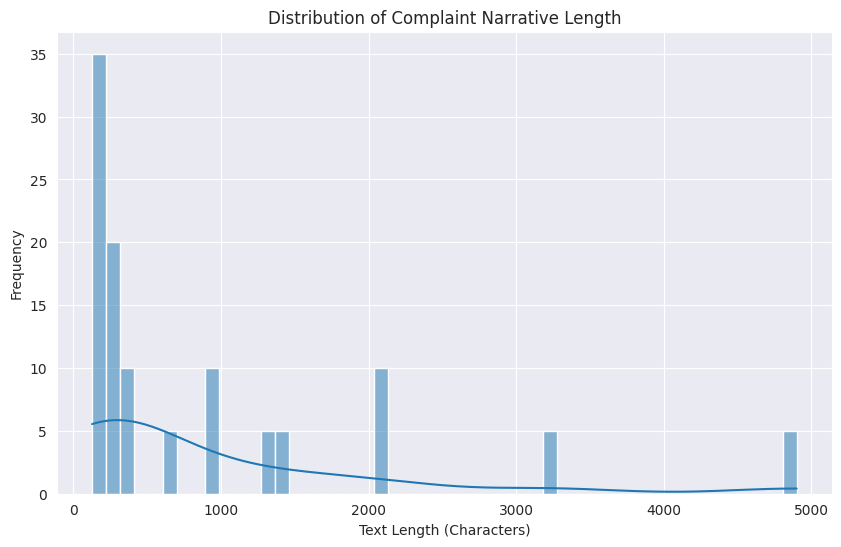

In [86]:
print("Distribution of target categories:")
print(df['category_id'].value_counts())

# Create a new feature for text length
df['text_length'] = df['narrative'].apply(len)

print("\nDescriptive statistics for text_length:")
print(df['text_length'].describe())

# Visualize the distribution of text_length
plt.figure(figsize=(10, 6))
sns.histplot(df['text_length'], bins=50, kde=True)
plt.title('Distribution of Complaint Narrative Length')
plt.xlabel('Text Length (Characters)')
plt.ylabel('Frequency')
plt.show()


## Text Pre-Processing

### Subtask:
Clean the 'consumer_complaint_narrative' text by removing special characters, numbers, and converting to lowercase. Tokenize the text, remove stopwords, and apply lemmatization. Display a sample of the processed text.


In [76]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove special characters and numbers
    text = re.sub(r'[^a-z\s]', '', text)
    # Tokenize
    tokens = nltk.word_tokenize(text)
    # Remove stopwords and lemmatize
    cleaned_tokens = [
        lemmatizer.lemmatize(word) for word in tokens if word not in stop_words
    ]
    # Join back to string
    return ' '.join(cleaned_tokens)

# Apply preprocessing to the 'narrative' column
df['cleaned_narrative'] = df['narrative'].apply(preprocess_text)

print("First 5 entries of original and cleaned narratives:")
print(df[['narrative', 'cleaned_narrative']].head())

First 5 entries of original and cleaned narratives:
                                                                                                                                                                                                  narrative  \
3                                                                           Upon reviewing my credit report, I identified multiple accounts that appear to be fraudulent and were added without my consent.   
4   sent letters to aargon agency asking for validation of debt after the 30 day mark I didn't know the account had been sent to them the original account was with XXXXXXXX XXXX neither company never ...   
47                                                      Upon carefully reviewing my recent credit report, I identified several fraudulent accounts that appear to have been added without my authorization.   
70                                                                  Upon closely reviewing my latest credit report, I fo

## Feature Extraction using TF-IDF

### Subtask:
Convert the pre-processed text data into numerical features using TF-IDF (Term Frequency-Inverse Document Frequency) vectorization.


In [77]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000) # Limiting to 5000 features for manageable size
X_tfidf = tfidf_vectorizer.fit_transform(df['cleaned_narrative'])

print("Shape of TF-IDF features (X_tfidf):")
print(X_tfidf.shape)
print("First 5 feature names:")
print(tfidf_vectorizer.get_feature_names_out()[:5])

Shape of TF-IDF features (X_tfidf):
(110, 617)
First 5 feature names:
['aargon' 'aargons' 'ability' 'accept' 'according']


## Split Data into Training and Testing Sets

### Subtask:
Split the pre-processed and vectorized dataset into training and testing sets to prepare for model training and evaluation.


In [79]:
X = X_tfidf
y = df['category_id']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (88, 617)
Shape of X_test: (22, 617)
Shape of y_train: (88,)
Shape of y_test: (22,)


## Train and Evaluate Multiple Classification Models

### Subtask:
Train and evaluate multiple multi-classification models including Logistic Regression, Multinomial Naive Bayes, Linear SVC, and RandomForest Classifier using the training data. For each model, report accuracy, precision, recall, and F1-score on the test set.


In [81]:
model_results = {}

models = [
    ('Logistic Regression', LogisticRegression(max_iter=1000, random_state=42)),
    ('Multinomial Naive Bayes', MultinomialNB()),
    ('Linear SVC', LinearSVC(dual=False, random_state=42)), # Set dual=False when n_samples > n_features
    ('RandomForest Classifier', RandomForestClassifier(random_state=42))
]

for name, model in models:
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

    model_results[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    }

    print(f"{name} Performance:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")

print("\nModel training and evaluation complete.")


Training Logistic Regression...
Logistic Regression Performance:
  Accuracy: 0.9091
  Precision: 0.8264
  Recall: 0.9091
  F1-Score: 0.8658

Training Multinomial Naive Bayes...
Multinomial Naive Bayes Performance:
  Accuracy: 1.0000
  Precision: 1.0000
  Recall: 1.0000
  F1-Score: 1.0000

Training Linear SVC...
Linear SVC Performance:
  Accuracy: 1.0000
  Precision: 1.0000
  Recall: 1.0000
  F1-Score: 1.0000

Training RandomForest Classifier...
RandomForest Classifier Performance:
  Accuracy: 1.0000
  Precision: 1.0000
  Recall: 1.0000
  F1-Score: 1.0000

Model training and evaluation complete.


## Compare Model Performance

### Subtask:
Compare the performance of the trained models using metrics such as accuracy, and visualize their performance using a bar chart. Provide a clear legend for the visualization.


**Reasoning**:
First, I will convert the `model_results` dictionary into a pandas DataFrame to facilitate plotting and then display the DataFrame.



In [82]:
performance_df = pd.DataFrame(model_results).T
print(performance_df)

                         Accuracy  Precision    Recall  F1-Score
Logistic Regression      0.909091   0.826446  0.909091  0.865801
Multinomial Naive Bayes  1.000000   1.000000  1.000000  1.000000
Linear SVC               1.000000   1.000000  1.000000  1.000000
RandomForest Classifier  1.000000   1.000000  1.000000  1.000000


**Reasoning**:
I will create a bar chart to visualize the 'Accuracy', 'Precision', 'Recall', and 'F1-Score' for each model, ensuring the plot has appropriate labels, a descriptive title, and a clear legend.



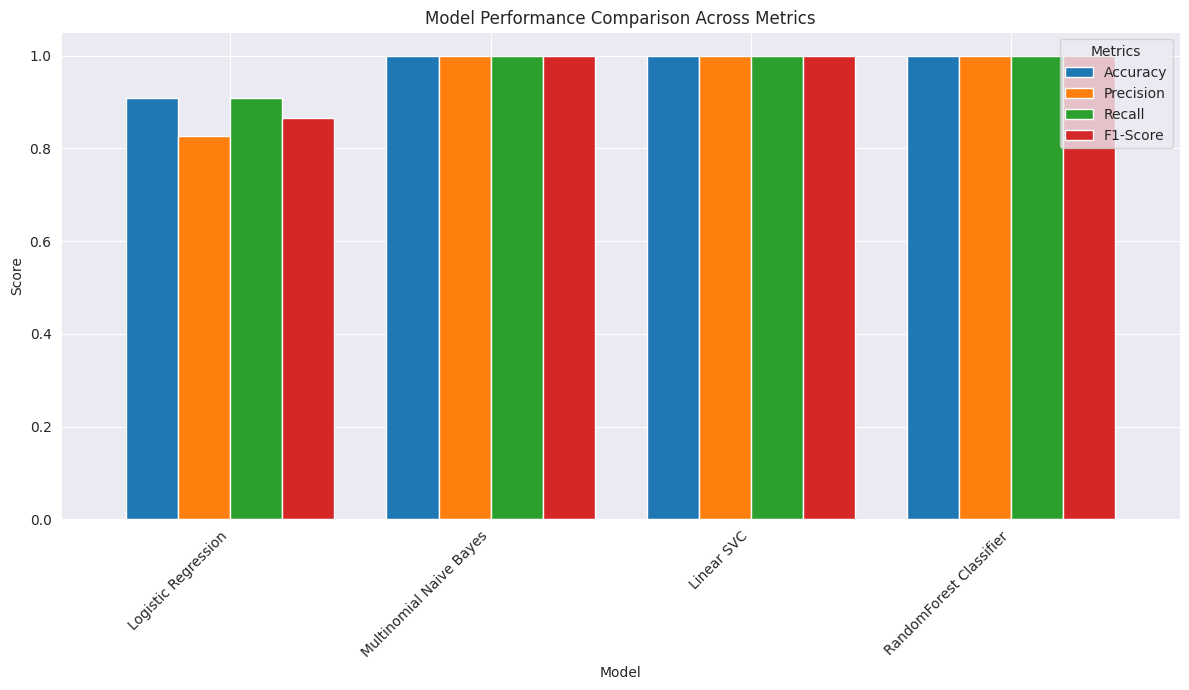

In [87]:
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
performance_df[metrics].plot(kind='bar', figsize=(12, 7), width=0.8)
plt.title('Model Performance Comparison Across Metrics')
plt.xlabel('Model')
plt.ylabel('Score')
plt.ylim(0, 1.05) # Set y-axis limit from 0 to 1.05 for scores
plt.xticks(rotation=45, ha='right')
plt.legend(title='Metrics')
plt.tight_layout()
plt.show()

## Detailed Model Evaluation

### Subtask:
Select the best-performing model and perform a detailed evaluation, including generating a confusion matrix and a classification report for a deeper understanding of its performance across different categories.


In [92]:
best_model_name = 'Multinomial Naive Bayes'
best_model = MultinomialNB()
best_model.fit(X_train, y_train)
y_pred_best = best_model.predict(X_test)

print(f"Best model chosen: {best_model_name}")

print("\nClassification Report for Best Model (Multinomial Naive Bayes):")
print(classification_report(y_test, y_pred_best, target_names=[str(name) for name in sorted(y.unique())], zero_division=0))

cm = confusion_matrix(y_test, y_pred_best)
print("Confusion Matrix for Best Model (Multinomial Naive Bayes):")
print(cm)

Best model chosen: Multinomial Naive Bayes

Classification Report for Best Model (Multinomial Naive Bayes):
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        20
           3       1.00      1.00      1.00         2

    accuracy                           1.00        22
   macro avg       1.00      1.00      1.00        22
weighted avg       1.00      1.00      1.00        22

Confusion Matrix for Best Model (Multinomial Naive Bayes):
[[20  0]
 [ 0  2]]


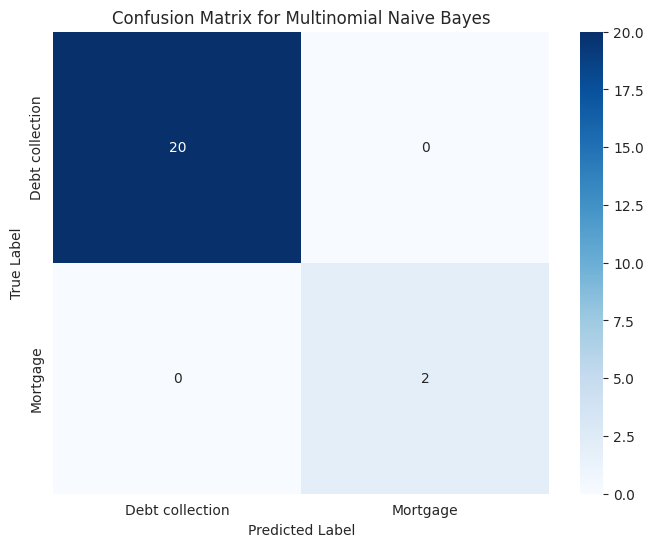

In [93]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[product_names[i] for i in sorted(y.unique())],
            yticklabels=[product_names[i] for i in sorted(y.unique())])
plt.title('Confusion Matrix for Multinomial Naive Bayes')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Prediction on Sample Data

### Subtask:
Use the best-performing model to make predictions on a few sample consumer complaints from the test set or new unseen data to demonstrate its functionality.


In [95]:
sample_complaints = [
    "I am constantly getting calls about a debt I do not owe. This is harassment.",
    "My mortgage payment increased unexpectedly without any prior notification or clear explanation from the bank.",
    "I need to dispute an inaccurate item on my credit report that is affecting my score.",
    "I took out a personal loan and now the interest rates are much higher than agreed upon.",
    "I received a letter demanding payment for a medical bill that I already paid last year."
]

# Create a reverse mapping for category_id to product name
id_to_category = {
    0: 'Credit reporting, credit repair services, or other',
    1: 'Debt collection',
    2: 'Consumer Loan',
    3: 'Mortgage'
}

# Preprocess the sample complaints
processed_sample_complaints = [preprocess_text(complaint) for complaint in sample_complaints]

print("Original sample complaints:")
for i, complaint in enumerate(sample_complaints):
    print(f"{i+1}. {complaint}")

print("\nProcessed sample complaints:")
for i, p_complaint in enumerate(processed_sample_complaints):
    print(f"{i+1}. {p_complaint}")

Original sample complaints:
1. I am constantly getting calls about a debt I do not owe. This is harassment.
2. My mortgage payment increased unexpectedly without any prior notification or clear explanation from the bank.
3. I need to dispute an inaccurate item on my credit report that is affecting my score.
4. I took out a personal loan and now the interest rates are much higher than agreed upon.
5. I received a letter demanding payment for a medical bill that I already paid last year.

Processed sample complaints:
1. constantly getting call debt owe harassment
2. mortgage payment increased unexpectedly without prior notification clear explanation bank
3. need dispute inaccurate item credit report affecting score
4. took personal loan interest rate much higher agreed upon
5. received letter demanding payment medical bill already paid last year


In [96]:
X_sample = tfidf_vectorizer.transform(processed_sample_complaints)

# Make predictions
predicted_category_ids = best_model.predict(X_sample)

print("\nPredictions for sample complaints:")
for i, complaint in enumerate(sample_complaints):
    predicted_product_name = id_to_category[predicted_category_ids[i]]
    print(f"Original Complaint {i+1}: {complaint}")
    print(f"Predicted Category: {predicted_product_name}\n")


Predictions for sample complaints:
Original Complaint 1: I am constantly getting calls about a debt I do not owe. This is harassment.
Predicted Category: Debt collection

Original Complaint 2: My mortgage payment increased unexpectedly without any prior notification or clear explanation from the bank.
Predicted Category: Debt collection

Original Complaint 3: I need to dispute an inaccurate item on my credit report that is affecting my score.
Predicted Category: Debt collection

Original Complaint 4: I took out a personal loan and now the interest rates are much higher than agreed upon.
Predicted Category: Debt collection

Original Complaint 5: I received a letter demanding payment for a medical bill that I already paid last year.
Predicted Category: Debt collection



In [104]:
print("\nFetching a new random set of complaints from the API...")

new_complaints_count = 1000 # Number of new complaints to fetch
new_offset = np.random.randint(0, 10000) # Random offset to get different complaints

new_complaints = []
endpoint_new = f"?size={new_complaints_count}&from={new_offset}"
full_url_new = API_BASE_URL + endpoint_new

try:
    response_new = requests.get(full_url_new, headers=headers)
    response_new.raise_for_status()
    data_new = response_new.json()

    if 'hits' in data_new and data_new['hits']['hits']:
        new_complaints.extend(data_new['hits']['hits'])
        print(f"Successfully fetched {len(data_new['hits']['hits'])} new complaints.")
    else:
        print("No new complaints found or unexpected response.")
except requests.exceptions.RequestException as e:
    print(f"Error fetching new data: {e}")

processed_new_complaints = []
original_new_complaints_text = []

for complaint in new_complaints:
    source_data = complaint.get('_source', {})
    narrative = source_data.get('complaint_what_happened')
    product = source_data.get('product') # Keep original product for comparison if needed, but not used for prediction input

    if narrative:
        original_new_complaints_text.append(narrative)
        processed_new_complaints.append(preprocess_text(narrative))

if not processed_new_complaints:
    print("No valid new narratives found to predict.")
else:
    # Transform the processed new complaints using the fitted TF-IDF vectorizer
    X_new_sample = tfidf_vectorizer.transform(processed_new_complaints)

    # Make predictions
    predicted_new_category_ids = best_model.predict(X_new_sample)

    print("\nPredictions for new sample complaints from API:")
    for i, original_text in enumerate(original_new_complaints_text):
        predicted_product_name = id_to_category.get(predicted_new_category_ids[i], "Unknown Category")
        print(f"New Complaint {i+1}:")
        print(f"  Original Text: {original_text[:150]}...") # Print a snippet
        print(f"  Predicted Category: {predicted_product_name}\n")


Fetching a new random set of complaints from the API...
Successfully fetched 1000 new complaints.

Predictions for new sample complaints from API:
New Complaint 1:
  Original Text: Chae bank called me about a fraudulent case application. They gave me a case number XXXX, tranferred me CFPB. During the call, long silent when agent ...
  Predicted Category: Debt collection

New Complaint 2:
  Original Text: The inclusion of these unauthorized accounts and inquiries has caused considerable stress and concern regarding my financial well-being. It is imperat...
  Predicted Category: Debt collection

New Complaint 3:
  Original Text: I respectfully seek your comprehension regarding the late remarks on my report, and I am fully dedicated to resolving them as per our agreement. My go...
  Predicted Category: Debt collection

New Complaint 4:
  Original Text: Upon reviewing my credit report, I identified multiple accounts that appear to be fraudulent and were added without my consent....
  Pred